# Layer-wise CLS representation analysis (BERT)

In [12]:
import sys
import os

sys.path.append(os.path.abspath(r"C:\Users\hp\Desktop\bert_layerwise_negation"))

## imports:

In [13]:
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel

from models.bert_probe import BertLayerProbe
from utils.metrics import cosine_similarity

## initializing model:

In [14]:
probe = BertLayerProbe()

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


## Evaluation Function:

In [15]:
def evaluate_category(file_path):
    with open(file_path, "r") as f:
        pairs = json.load(f)

    similarities = []

    for pair in pairs:
        s1 = pair["sentence1"].strip()
        s2 = pair["sentence2"].strip()

        cls1 = probe.get_cls_per_layer(s1)
        cls2 = probe.get_cls_per_layer(s2)

        layer_sims = []
        for i in range(len(cls1)):
            sim = cosine_similarity(cls1[i], cls2[i])
            layer_sims.append(sim)

        similarities.append(layer_sims)

    similarities = np.array(similarities)

    mean = similarities.mean(axis=0)
    std = similarities.std(axis=0)

    return similarities, mean, std

## loading data:

In [16]:
exact_sim, exact_mean, exact_std = evaluate_category("../data/exact_pairs.json")
syn_sim, syn_mean, syn_std = evaluate_category("../data/synonym_pairs.json")
ant_sim, ant_mean, ant_std = evaluate_category("../data/antonym_pairs.json")
neg_sim, neg_mean, neg_std = evaluate_category("../data/negation_pairs.json")

## exporting result to the csv:

In [17]:
import pandas as pd

results_df = pd.DataFrame({
    "Layer": list(range(13)),
    "Exact_Mean": exact_mean,
    "Synonym_Mean": syn_mean,
    "Antonym_Mean": ant_mean,
    "Negation_Mean": neg_mean
})

results_df.to_csv("../results/similarity_results.csv", index=False)

results_df

,Layer,Exact_Mean,Synonym_Mean,Antonym_Mean,Negation_Mean
0,0,1.0,1.000000,1.000000,1.000000
1,1,1.0,0.999640,0.999419,0.996506
2,2,1.0,0.999040,0.998688,0.996695
3,3,1.0,0.999149,0.998872,0.997011
4,4,1.0,0.997773,0.997713,0.996818
5,5,1.0,0.996462,0.996094,0.994528
6,6,1.0,0.994262,0.992814,0.987303
7,7,1.0,0.985088,0.980863,0.969323
8,8,1.0,0.984712,0.981096,0.966017
9,9,1.0,0.975932,0.966765,0.932602


## comparative plot:

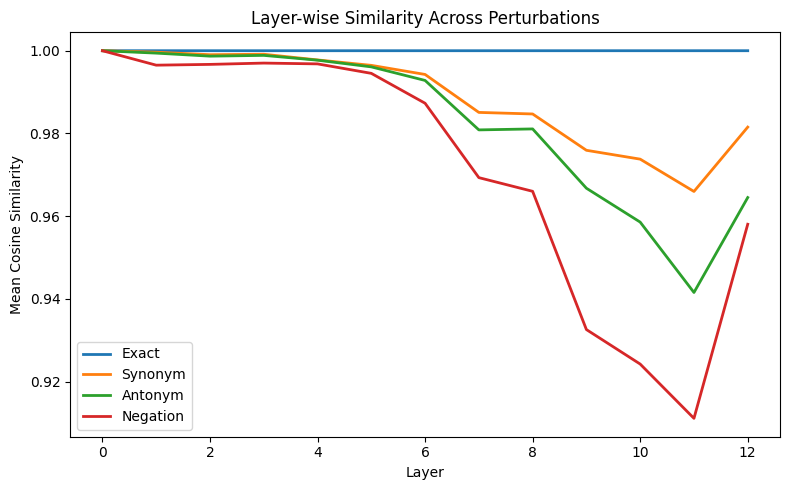

In [18]:
plt.figure(figsize=(8,5))

plt.plot(range(13), exact_mean, label="Exact", linewidth=2)
plt.plot(range(13), syn_mean, label="Synonym", linewidth=2)
plt.plot(range(13), ant_mean, label="Antonym", linewidth=2)
plt.plot(range(13), neg_mean, label="Negation", linewidth=2)

plt.xlabel("Layer")
plt.ylabel("Mean Cosine Similarity")
plt.title("Layer-wise Similarity Across Perturbations")
plt.legend()
plt.tight_layout()
plt.show()

In [19]:
def summarize(name, mean_array):
    min_val = mean_array.min()
    min_layer = mean_array.argmin()
    print(f"{name}: Minimum similarity = {min_val:.4f} at Layer {min_layer}")

summarize("Exact", exact_mean)
summarize("Synonym", syn_mean)
summarize("Antonym", ant_mean)
summarize("Negation", neg_mean)

Exact: Minimum similarity = 1.0000 at Layer 5
Synonym: Minimum similarity = 0.9660 at Layer 11
Antonym: Minimum similarity = 0.9416 at Layer 11
Negation: Minimum similarity = 0.9111 at Layer 11


## Standard Deviation Plot:

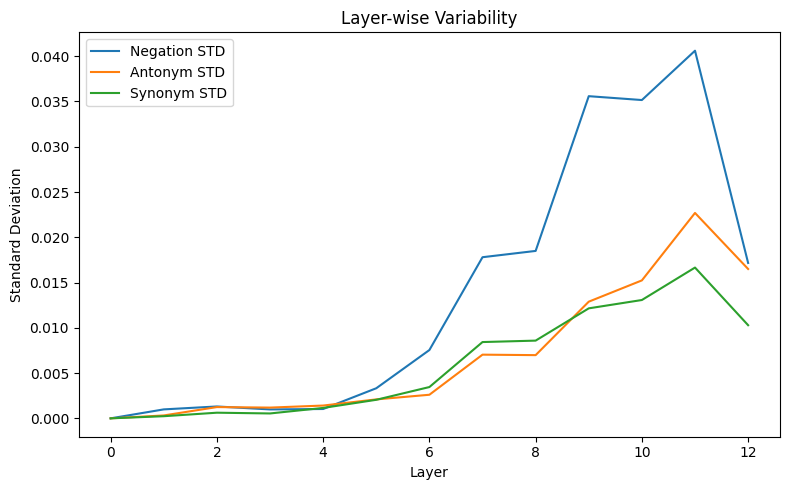

In [20]:
plt.figure(figsize=(8,5))

plt.plot(range(13), neg_std, label="Negation STD")
plt.plot(range(13), ant_std, label="Antonym STD")
plt.plot(range(13), syn_std, label="Synonym STD")

plt.xlabel("Layer")
plt.ylabel("Standard Deviation")
plt.title("Layer-wise Variability")
plt.legend()
plt.tight_layout()
plt.show()

## Statistical Testing

In [21]:
def run_ttest(category_name, category_similarities):
    print(f"\n{category_name} vs Exact:")
    for layer in range(13):
        t_stat, p_val = ttest_rel(exact_sim[:, layer], category_similarities[:, layer])
        print(f"Layer {layer}: p = {p_val:.6f}")

run_ttest("Synonym", syn_sim)
run_ttest("Antonym", ant_sim)
run_ttest("Negation", neg_sim)


Synonym vs Exact:
Layer 0: p = nan
Layer 1: p = 0.001323
Layer 2: p = 0.001244
Layer 3: p = 0.001074
Layer 4: p = 0.000256
Layer 5: p = 0.000578
Layer 6: p = 0.000760
Layer 7: p = 0.000488
Layer 8: p = 0.000467
Layer 9: p = 0.000217
Layer 10: p = 0.000199
Layer 11: p = 0.000173
Layer 12: p = 0.000442

Antonym vs Exact:
Layer 0: p = nan
Layer 1: p = 0.000405
Layer 2: p = 0.011476
Layer 3: p = 0.019046
Layer 4: p = 0.000899
Layer 5: p = 0.000334
Layer 6: p = 0.000017
Layer 7: p = 0.000019
Layer 8: p = 0.000020
Layer 9: p = 0.000029
Layer 10: p = 0.000019
Layer 11: p = 0.000029
Layer 12: p = 0.000118

Negation vs Exact:
Layer 0: p = nan
Layer 1: p = 0.000002
Layer 2: p = 0.000035
Layer 3: p = 0.000008
Layer 4: p = 0.000007
Layer 5: p = 0.000802
Layer 6: p = 0.000692
Layer 7: p = 0.000586
Layer 8: p = 0.000374
Layer 9: p = 0.000301
Layer 10: p = 0.000116
Layer 11: p = 0.000103
Layer 12: p = 0.000044
